In [2]:
import numpy as np
from sklearn.mixture import GMM
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
from sklearn.metrics import confusion_matrix

%matplotlib inline

from sklearn.externals import joblib

In [3]:
mfcc_original_train = np.loadtxt('./featurevec/mfcc_train_human.txt')

mfcc_spoof_train = np.loadtxt('./featurevec/mfcc_spoof_train.txt')

mfcc_original_develop = np.loadtxt('./featurevec/mfcc_dev_human.txt')

mfcc_spoof_develop = np.loadtxt('./featurevec/mfcc_spoof_dev.txt')

mfcc_original_test = np.loadtxt('./featurevec/mfcc_eva_human.txt')

mfcc_spoof_test = np.loadtxt('./featurevec/mfcc_spoof_eva.txt')

In [4]:
X_train = np.concatenate([mfcc_original_train, mfcc_spoof_train]) 
y_train = np.concatenate([np.zeros((mfcc_original_train.shape[0])), np.ones((mfcc_spoof_train.shape[0]))]).astype('int')

X_develop = np.concatenate([mfcc_original_develop, mfcc_spoof_develop]) 
y_develop = np.concatenate([np.zeros((mfcc_original_develop.shape[0])), np.ones((mfcc_spoof_develop.shape[0]))]).astype('int')

X_test = np.concatenate([mfcc_original_test, mfcc_spoof_test]) 
y_test = np.concatenate([np.zeros((mfcc_original_test.shape[0])), np.ones((mfcc_spoof_test.shape[0]))]).astype('int')

In [5]:
def computeUBM(ubm_model, data):
    ###########################################
    # ubm_model - gmm-represent distribution of our model
    # data - samples, which will correct ubm-model
    ###############################################

    xdim = data.shape[1]
    M = ubm_model.n_components

    ###############################################################
    #    ubm_means: means of the ubm <number array>               #
    #    ubm_covars: covariances of the ubm <number array>        #
    #    ubm_weights: weights of the ubm <number array>           #
    #    new_means: means adapted from the ubm <number array>     #
    #    new_weights: weights adapted from the ubm <number array> #
    ###############################################################

    # Copy parameters GMM-model
    ubm_weights = ubm_model.weights_
    ubm_means = ubm_model.means_
    ubm_covars = ubm_model.covars_

    ###################################################################
    # for X = {x_1, ..., x_T}                                         #
    # P(i|x_t) = w_i * p_i(x_t) / sum_j=1_M(w_j * P_j(x_t))           #
    ###################################################################

    posterior_prob = ubm_model.predict_proba(data)
    pr_i_xt = (ubm_weights * posterior_prob) / np.asmatrix(np.sum(ubm_weights \
                                                                  * posterior_prob, axis=1)).T

    n_i = np.asarray(np.sum(pr_i_xt, axis=0)).flatten()  # [M, ]

    # Then we can compute E(x) and E(x2) and calculate new parameters of
    # our model

    E_x = np.asarray([(np.asarray(pr_i_xt[:, i]) * data).sum(axis=0) / n_i[i] if not n_i[i] == 0. else np.zeros(xdim) for i in range(M)])  # [M x xdim]
    E_x2 = np.asarray([(np.asarray(pr_i_xt[:, i]) * (data ** 2)).sum(axis=0) / n_i[i]  if not n_i[i] == 0. else np.zeros(xdim)for i in range(M)])  # [M x xdim]

    ################################################################
    #    T: scaling factor, number of samples                      #
    #    relevance_factor: factor for scaling the adapted means    #
    #    scaleparam - scale parameter for weights matrix estimation#
    ################################################################

    T = data.shape[0]
    relevance_factor = 16
    scaleparam = 1

    ################################################################
    # compute alpha_i: data-depentend apaptation coefficient       #
    # alpha_w = alpha_m = alpha_v                                  #
    # alpha_i = n_i/ (n_i + relevance factor)                      #
    ################################################################

    alpha_i = n_i / (n_i + relevance_factor)

    ###############################
    # Parqameter`s adaptation
    ##############################
    new_weights = (alpha_i * n_i / T + (1.0 - alpha_i) * ubm_weights) * scaleparam

    alpha_i = np.asarray(np.asmatrix(alpha_i).T)
    new_means = (alpha_i * E_x + (1. - alpha_i) * ubm_means)
    new_covars = alpha_i * E_x2 + (1. - alpha_i) * (ubm_covars + (ubm_means ** 2)) - (new_means ** 2)

    ubm_model.means_ = new_means
    ubm_model.weights_ = new_weights
    ubm_model.covars_ = new_covars

    return ubm_model

# train GMM-ML

In [ ]:
g = np.array([2,4,8,16,32,64,128,256,512,1024])

for n_g in [1024]:
    gmm_1 =  GMM(n_components = n_g, covariance_type='diag',init_params='wmc', n_iter=20)
    gmm_1.fit(mfcc_original_train)

    gmm_2 =  GMM(n_components = n_g, covariance_type='diag',init_params='wmc', n_iter=20)
    gmm_2.fit(mfcc_spoof_train)

    filename1 = './mixtureModels/gmm_1_'+str(n_g)+ 'gaussian.pkl'
    joblib.dump(gmm_1, filename1) 
    
    filename2 = './mixtureModels/gmm_2_'+str(n_g)+ 'gaussian.pkl'
    joblib.dump(gmm_2, filename2) 

In [5]:
m1 = joblib.load('./mixtureModels/gmm_1_1024gaussian.pkl')
m2 = joblib.load('./mixtureModels/gmm_2_1024gaussian.pkl')

scores_dev  = np.array(m2.score(X_develop) - m1.score(X_develop))

In [29]:
label_th0_dev = (scores_dev > 0).astype('int')
    
accuracy_th0_dev = np.mean(label_th0_dev == y_develop) * 100

print 'learn train, TH = 0, predict develop\n'
print 'accuracy on develop set', accuracy_th0_dev

##################
#    TN     FP   #
#    FN     TP   #
##################
print '\nCM:\n', confusion_matrix(y_develop, label_th0_dev )

learn train, TH = 0, predict develop

accuracy on develop set 77.3645357116

CM:
[[ 1691  1806]
 [10275 39600]]


In [30]:
scores_test  = np.array(m2.score(X_test) - m1.score(X_test))
label_test_gmm= (scores_test > 0).astype('int')

acc_test_gmm = np.mean(label_test_gmm == y_test) * 100
cm_GMM_eva =  confusion_matrix(y_test,label_test_gmm )

print 'learn train, TH = 0, predict eva\n'
print 'accuracy  on test', acc_test_gmm
print '\nCM:\n', cm_GMM_eva

learn train, TH = 0, predict eva

accuracy  on test 73.5067527042

CM:
[[  4530   4874]
 [ 46365 137635]]


In [32]:
s = np.sum(cm_GMM_eva)

print "TN = {}, FP = {}, FN = {}".format(cm_GMM_eva[0][0].astype('float')/s, cm_GMM_eva[0][1].astype('float')/s,cm_GMM_eva[1][0].astype('float')/s)

TN = 0.023422473165, FP = 0.0252011333788, FN = 0.239731339579


# find optimal threshold



In [6]:
def Find_Optimal_Threshold(target, scores):

    fpr, tpr, threshold = roc_curve(target, scores)
    
    # Найдем оптимальный порог для принятия решений
    
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    print 'Threshold:'
    print roc_t
    return np.array(roc_t['threshold'])


In [17]:
# Compute optimal treshold and calc accuracy (development set)
threshold_dev = Find_Optimal_Threshold(y_develop, scores_dev)
print threshold_dev

            tf  threshold
5400  0.000003    1.75438
[ 1.75438005]


делаем предсказания с учетов нового порога для модели GMM-ML на development set

In [33]:
labels_dev = (scores_dev > threshold_dev).astype('int')   
accuracy_dev_newTH = np.mean(labels_dev == y_develop) * 100
cm_GMM_dev_TH_NEW = confusion_matrix(y_develop, labels_dev)

print 'learn train, TH = 0, predict develop\n'
print 'accuracy - prediction on development set', accuracy_dev_newTH

print '\nCM:\n', cm_GMM_dev_TH_NEW



learn train, TH = 0, predict develop

accuracy - prediction on development set 67.4885707862

CM:
[[ 2361  1136]
 [16216 33659]]


Предсказания на тестовом наборе данных (evaluation) с учетом порога

In [34]:
labels_test = (scores_test > threshold_dev).astype('int')
cm_GMM_eva_TH_NEW = confusion_matrix(y_test, labels_test)

accuracy_test = np.mean(labels_test == y_test) * 100
print 'accuracy - prediction on evaluation set', accuracy_test
print '\nCM:\n', cm_GMM_eva_TH_NEW

accuracy - prediction on evaluation set 61.7841409692

CM:
[[  6736   2668]
 [ 71243 112757]]


# ROC

In [7]:
def plotROC(true, predicted, ttl = None):
    fpr, tpr, threshold = roc_curve(true, predicted, pos_label = 1)
    roc_auc = auc(fpr, tpr)

    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(ttl)
    plt.legend(loc="lower right")
    plt.show()

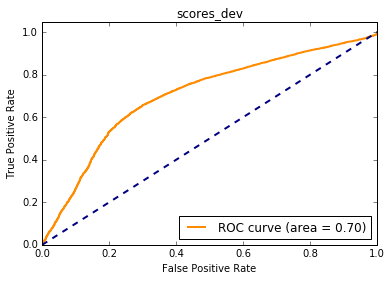

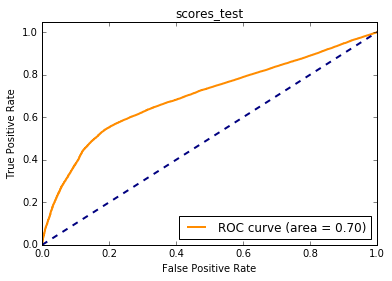

In [36]:
plotROC(y_develop, scores_dev, "scores_dev")

plotROC(y_test, scores_test, "scores_test")

# make prediction with new threshold


#  train ubm_models

In [13]:
gaussians = np.array([2,4,8,16,32,64,128,256,512,1024])

for n_g in [1024]:
    ubm =  GMM(n_components = n_g, covariance_type='diag',init_params='wmc', n_iter=20)
    ubm.fit(X_train, y_train)
    filename = './mixtureModels/ubm_'+str(n_g)+ 'gaussian.pkl'
    joblib.dump(ubm, filename) 

## predictions for UBM

In [ ]:
ubm_1 = joblib.load('./mixtureModels/ubm_1024gaussian.pkl')
ubm_2 = joblib.load('./mixtureModels/ubm_1024gaussian.pkl')

In [ ]:
num_iter = 15
for i in range(num_iter):
    
    if i == 0:
        ubm_1 = joblib.load('./mixtureModels/ubm_1024gaussian.pkl')
        ubm_2 = joblib.load('./mixtureModels/ubm_1024gaussian.pkl')
    else:
        ubm_1 = joblib.load('./mixtureModels/ubm/ubm_' + str(i)+ '_1.pkl')
        ubm_2 = joblib.load('./mixtureModels/ubm/ubm_' + str(i)+ '_2.pkl')
    ubm_1_adapt = computeUBM(ubm_1, mfcc_original_develop)
    ubm_2_adapt = computeUBM(ubm_2, mfcc_spoof_develop)
    
    ubm_scores_dev = np.array(ubm_2_adapt.score(X_develop)-  ubm_1_adapt.score(X_develop))
    ubm_labels_dev_th0 = (ubm_scores_dev > 0)
    
    ubm_accuracy_dev_th0 = np.mean(ubm_labels_dev_th0 == y_develop) * 100
    print 'accuracy - prediction on development set. Th = 0: ', ubm_accuracy_dev_th0    

    ubm_scores_eva = np.array(ubm_2_adapt.score(X_test)-  ubm_1_adapt.score(X_test))
    ubm_labels_eva_th0 = (ubm_scores_eva > 0)
    ubm_accuracy_eva_th0 = np.mean(ubm_labels_eva_th0 == y_test) * 100
    print 'accuracy - prediction on test set. Th = 0: ', ubm_accuracy_eva_th0 
    CM_eva_th0= confusion_matrix(y_test, ubm_labels_eva_th0)
    print CM_eva_th0
    print '=================================================\n'
    
    ############################ THRESHOLD ###########################
    ubm_threshold = Find_Optimal_Threshold(y_develop, ubm_scores_dev)
    
    ubm_labels_eva_optTH = (ubm_scores_eva > ubm_threshold)
    ubm_accuracy_eva = np.mean(ubm_labels_eva_optTH == y_test) * 100
    print 'accuracy - prediction on development set, Th = Optimal', ubm_accuracy_eva     
    CM_eva_thOpt =  confusion_matrix(y_test, ubm_labels_eva_optTH)    
    print CM_eva_thOpt
    title = "scores_eva_ ubm. iter = ", i
    plotROC(y_test, ubm_scores_eva, title)
    
    
    joblib.dump(ubm_1_adapt, './mixtureModels/ubm/ubm_' + str(i+1)+ '_1.pkl') 
    joblib.dump(ubm_2_adapt, './mixtureModels/ubm/ubm_' + str(i+1)+ '_2.pkl')   
    print '=================================== NEW ITER========'